In [87]:
from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import yfinance as yf

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

## 3. The Data

In [118]:
start_date="2010-01-01"
dataset_ex_df=yf.download("GS",start=start_date)
dataset_ex_df.iloc[2105]


[*********************100%***********************]  1 of 1 completed


Open         2.436000e+02
High         2.458800e+02
Low          2.435000e+02
Close        2.439100e+02
Adj Close    2.268556e+02
Volume       1.928526e+06
Name: 2018-05-14 00:00:00, dtype: float64

In [119]:
dataset_ex_df=dataset_ex_df["Close"]

In [104]:
dataset_ex_df.head()

Date
2009-12-31    168.839996
2010-01-04    173.080002
2010-01-05    176.139999
2010-01-06    174.259995
2010-01-07    177.669998
Name: Close, dtype: float64

In [15]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 3008 number of days in the dataset.


In [29]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))
                                    

Number of training days: 2105. Number of test days: 903.


In [44]:
dataset_ex_df

Date
2009-12-31    168.839996
2010-01-04    173.080002
2010-01-05    176.139999
2010-01-06    174.259995
2010-01-07    177.669998
                 ...    
2021-12-06    389.299988
2021-12-07    400.109985
2021-12-08    397.320007
2021-12-09    396.489990
2021-12-10    391.059998
Name: Close, Length: 3008, dtype: float64

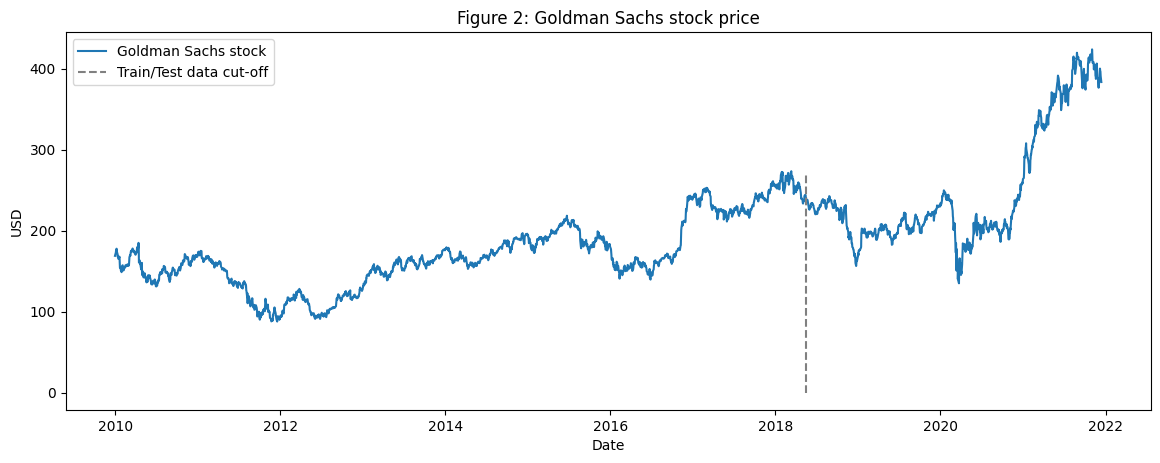

In [50]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df, label='Goldman Sachs stock')
plt.vlines(datetime.date(2018,5, 14), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

## 3.1 Correlated assets

In [158]:
competitor_df=yf.download("JPM MS",start=start_date)
competitor_df=competitor_df["Close"]
competitor_df

[*********************100%***********************]  2 of 2 completed


,JPM,MS
Date,,
2009-12-31,41.669998,29.600000
2010-01-04,42.849998,30.910000
2010-01-05,43.680000,32.040001
2010-01-06,43.919998,32.450001
2010-01-07,44.790001,32.919998
...,...,...
2021-12-07,162.570007,102.500000
2021-12-08,160.710007,101.250000
2021-12-09,160.460007,100.580002


In [159]:
global_df=yf.download("SPY ^FTSE ^N225 NDAQ ^VIX",start=start_date)
global_df=global_df["Close"]
global_df

[*********************100%***********************]  5 of 5 completed


,NDAQ,SPY,^FTSE,^N225,^VIX
Date,,,,,
2009-12-31,19.820000,111.440002,5412.899902,NaN,21.680000
2010-01-04,20.240000,113.330002,5500.299805,10654.790039,20.040001
2010-01-05,20.299999,113.629997,5522.500000,10681.830078,19.350000
2010-01-06,20.290001,113.709999,5530.000000,10731.450195,19.160000
2010-01-07,20.020000,114.190002,5526.700195,10681.660156,19.059999
...,...,...,...,...,...
2021-12-08,207.389999,469.519989,7337.399902,28860.619141,19.900000
2021-12-09,204.139999,466.350006,7321.299805,28725.470703,21.580000
2021-12-10,205.779999,470.739990,7291.799805,28437.769531,18.690001


In [86]:
eur_usd_df=pd.read_csv("HistoricalPrices.csv")
eur_usd_df

,Date,Open,High,Low,Close
0,12/10/21,1.1294,1.1324,1.1265,1.1318
1,12/09/21,1.1342,1.1348,1.1279,1.1293
2,12/08/21,1.1269,1.1357,1.1265,1.1343
3,12/07/21,1.1285,1.1300,1.1227,1.1267
4,12/06/21,1.1316,1.1320,1.1266,1.1286
...,...,...,...,...,...
3111,01/07/10,1.4411,1.4411,1.4308,1.4308
3112,01/06/10,1.4365,1.4411,1.4365,1.4411
3113,01/05/10,1.4413,1.4413,1.4365,1.4365
3114,01/04/10,1.4332,1.4413,1.4332,1.4413


In [164]:
dataset=pd.concat([dataset_ex_df,global_df,competitor_df],axis=1)
dataset=dataset.dropna()

## 3.2 Technical indicators

In [161]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create Bollinger Bands
    dataset['20sd'] = dataset["Close"].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    return dataset

In [165]:
dataset_TI_df = get_technical_indicators(dataset)
dataset_TI_df

,Close,NDAQ,SPY,^FTSE,^N225,^VIX,JPM,MS,ma7,ma21,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,
2010-01-04,173.080002,20.240000,113.330002,5500.299805,10654.790039,20.040001,42.849998,30.910000,NaN,NaN,NaN,NaN,NaN,173.080002
2010-01-05,176.139999,20.299999,113.629997,5522.500000,10681.830078,19.350000,43.680000,32.040001,NaN,NaN,NaN,NaN,NaN,175.375000
2010-01-06,174.259995,20.290001,113.709999,5530.000000,10731.450195,19.160000,43.919998,32.450001,NaN,NaN,NaN,NaN,NaN,174.603073
2010-01-07,177.669998,20.020000,114.190002,5526.700195,10681.660156,19.059999,44.790001,32.919998,NaN,NaN,NaN,NaN,NaN,176.673248
2010-01-08,174.309998,20.230000,114.570000,5534.200195,10798.320312,18.129999,44.680000,32.250000,NaN,NaN,NaN,NaN,NaN,175.091237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07,400.109985,205.550003,468.279999,7339.899902,28455.599609,21.889999,162.570007,102.500000,386.241429,394.941905,9.222367,413.386638,376.497171,395.846958
2021-12-08,397.320007,207.389999,469.519989,7337.399902,28860.619141,19.900000,160.710007,101.250000,387.781429,394.477144,8.653223,411.783591,377.170697,396.828991
2021-12-09,396.489990,204.139999,466.350006,7321.299805,28725.470703,21.580000,160.460007,100.580002,389.995714,393.912858,8.247207,410.407273,377.418443,396.602990


In [163]:
dataset

,Close,NDAQ,SPY,^FTSE,^N225,^VIX,JPM,MS,ma7,ma21,20sd,upper_band,lower_band,ema
Date,,,,,,,,,,,,,,
2009-12-31,168.839996,19.820000,111.440002,5412.899902,NaN,21.680000,41.669998,29.600000,NaN,NaN,NaN,NaN,NaN,168.839996
2010-01-04,173.080002,20.240000,113.330002,5500.299805,10654.790039,20.040001,42.849998,30.910000,NaN,NaN,NaN,NaN,NaN,172.020000
2010-01-05,176.139999,20.299999,113.629997,5522.500000,10681.830078,19.350000,43.680000,32.040001,NaN,NaN,NaN,NaN,NaN,174.872307
2010-01-06,174.259995,20.290001,113.709999,5530.000000,10731.450195,19.160000,43.919998,32.450001,NaN,NaN,NaN,NaN,NaN,174.458996
2010-01-07,177.669998,20.020000,114.190002,5526.700195,10681.660156,19.059999,44.790001,32.919998,NaN,NaN,NaN,NaN,NaN,176.608510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-08,397.320007,207.389999,469.519989,7337.399902,28860.619141,19.900000,160.710007,101.250000,387.781429,NaN,NaN,NaN,NaN,396.829018
2021-12-09,396.489990,204.139999,466.350006,7321.299805,28725.470703,21.580000,160.460007,100.580002,389.995714,NaN,NaN,NaN,NaN,396.602997
2021-12-10,391.059998,205.779999,470.739990,7291.799805,28437.769531,18.690001,159.820007,98.430000,392.078570,NaN,NaN,NaN,NaN,392.907650


In [154]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    plt.show()

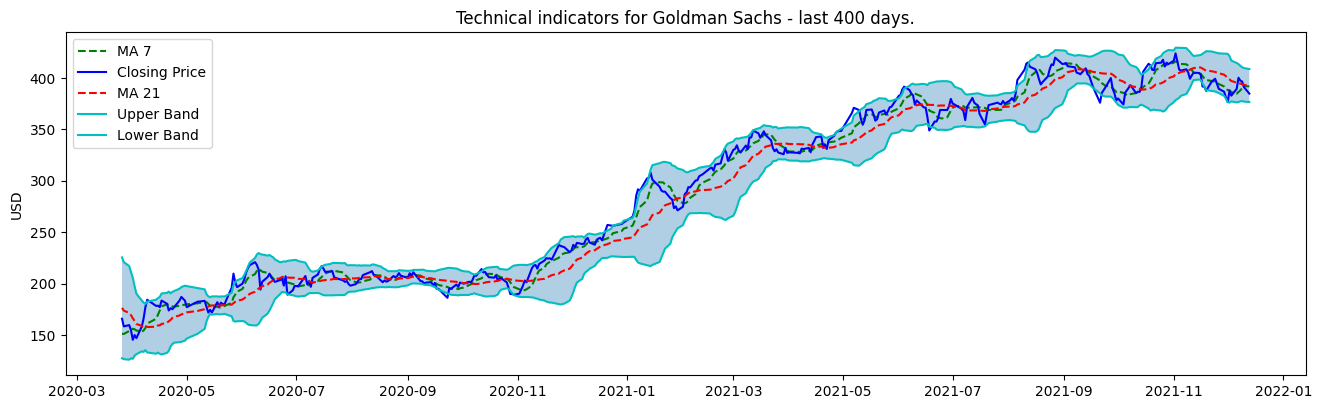

In [166]:
plot_technical_indicators(dataset,400)

In [156]:
dataset.isna().sum()

Close           98
NDAQ            98
SPY             98
^FTSE           87
^N225          185
^VIX            98
CSGN          1588
JPM             98
MS              98
ma7            686
ma21          1948
20sd          1877
upper_band    1948
lower_band    1948
ema              0
dtype: int64

## 3.3 Fundamental Analysis

## 3.4 Fourier transforms for trend analysis

In [196]:
dataset_ex_df=dataset_ex_df.dropna()
close_fft=np.fft.fft(np.asarray(dataset_ex_df.tolist()))
fft_df=pd.DataFrame({'fft':close_fft})
fft_df['absolute']=fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle']=fft_df['fft'].apply(lambda x: np.angle(x))
fft_df=fft_df.set_index(dataset_ex_df.index)
fft_df

,fft,absolute,angle
Date,,,
2009-12-31,582075.2156098+0.0000000j,582075.215698,0.000000
2010-01-04,19642.778980+75723.607597j,78229.812179,1.316989
2010-01-05,39792.524760+29114.495379j,49306.174745,0.631658
2010-01-06,55500.012319+19178.234529j,58720.150265,0.332708
2010-01-07,9886.022654+34374.620876j,35767.974562,1.290757
...,...,...,...
2021-12-07,7509.360749-14846.843044j,16637.885900,-1.102529
2021-12-08,9886.022654-34374.620876j,35767.974562,-1.290757
2021-12-09,55500.012319-19178.234529j,58720.150265,-0.332708


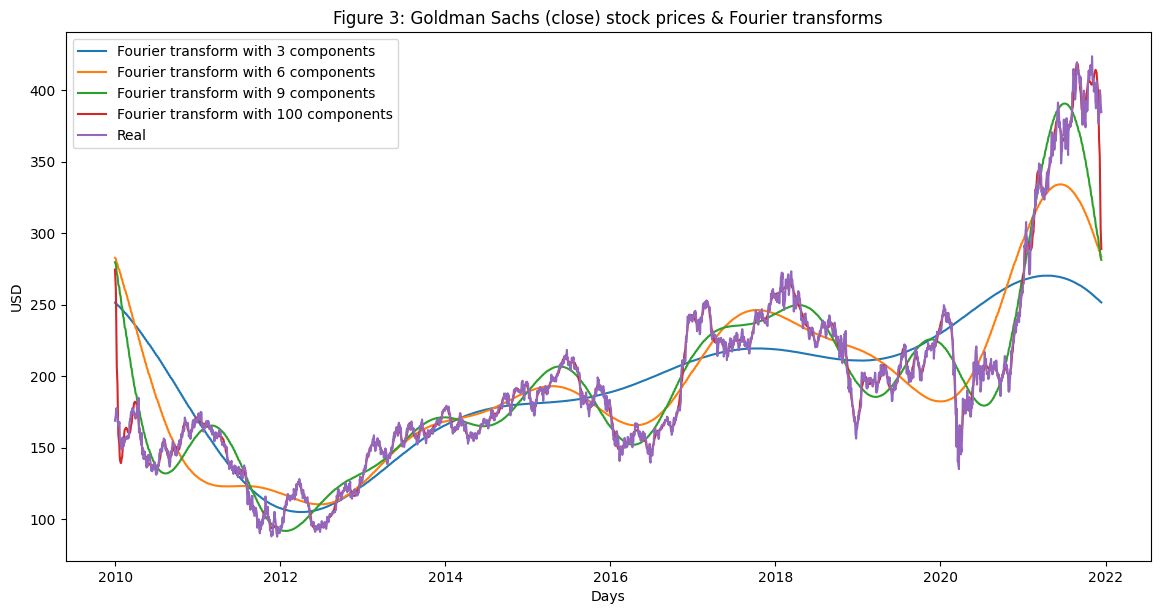

In [201]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(dataset_ex_df.index, np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(dataset_ex_df,  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

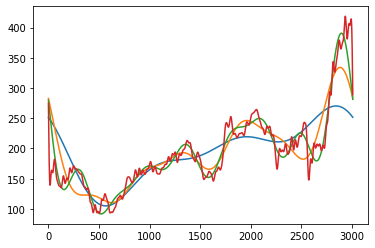

In [198]:
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

In [200]:
np.fft.ifft(fft_list_m10)

array([274.61940939-0.27568062j, 260.27742516-0.2877933j ,
       246.1219809 -0.28740289j, ..., 316.91410287-0.17214254j,
       303.12002383-0.21657124j, 288.96196955-0.25159108j])